In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import tree
from sklearn import preprocessing


In [2]:
telco_data =  pd.read_csv('https://raw.githubusercontent.com/cjflanagan/cs68/master/Telco-Customer-Churn.csv')

In [3]:
# force change TotalCharges type to number and remove nan
telco_data['TotalCharges'] = pd.to_numeric(telco_data['TotalCharges'], errors='coerce')
print('Number of NAN values: {}'.format(telco_data.TotalCharges.isna().sum()))
telco_data.dropna(inplace=True) # Dropping NANs
del telco_data['customerID'] # Removing as no information content

Number of NAN values: 8


In [4]:
telco_data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
# this is not terribly unbalanced data so ok to proceeded
telco_data.Churn.value_counts()
#telco_data.Churn.value_counts().plot(kind='barh', title='Churn counts')

No     3730
Yes    1332
Name: Churn, dtype: int64

In [6]:
telco_data.Churn = telco_data.Churn.replace({'Yes':1, 'No':0}) # Replacing 'Yes' and 'No' with numerical values

In [7]:
telco_data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [8]:
telco_data['Partner'] = telco_data.Partner.replace({'Yes':1, 'No':0}) 
telco_data['gender'] = telco_data.gender.replace({'Female':1, 'Male':0}) 

In [9]:
y = telco_data.pop('Churn') # Removing Churn field and storing it in variable y

In [10]:
categorical_cols = telco_data.columns[telco_data.dtypes=='object'].tolist()
categorical_cols

['Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [11]:
categorical_cols = ['InternetService', 'Contract', 'PaymentMethod']

In [12]:
features_data = telco_data[['MonthlyCharges', 'tenure', 'InternetService', 'Contract', 'PaymentMethod' ]]

In [13]:
# Create dummy variables
telco_data = pd.get_dummies(data = features_data, columns=categorical_cols, drop_first=False)
telco_data

,MonthlyCharges,tenure,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,29.85,1,1,0,0,1,0,0,0,0,1,0
1,56.95,34,1,0,0,0,1,0,0,0,0,1
2,53.85,2,1,0,0,1,0,0,0,0,0,1
3,42.30,45,1,0,0,0,1,0,1,0,0,0
4,70.70,2,0,1,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5065,24.90,33,0,0,1,0,1,0,1,0,0,0
5066,54.30,44,1,0,0,0,0,1,1,0,0,0
5067,66.30,30,1,0,0,1,0,0,1,0,0,0
5068,20.90,71,0,0,1,0,0,1,1,0,0,0


In [14]:
X = telco_data

# Splitting data

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.25)

In [16]:
X_train.head()

,MonthlyCharges,tenure,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
2204,111.30,67,0,1,0,0,1,0,0,0,1,0
12,100.35,58,0,1,0,0,1,0,0,1,0,0
993,26.10,10,0,0,1,0,0,1,0,1,0,0
1646,65.50,59,1,0,0,0,1,0,0,0,0,1
3202,55.25,1,1,0,0,1,0,0,0,0,1,0


# Decision Tree

In [17]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(max_depth=3)

print(dt_model)

dt_model = dt_model.fit(X_train,y_train)
pred_dt = dt_model.predict_proba(X_test)[:, 1]

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


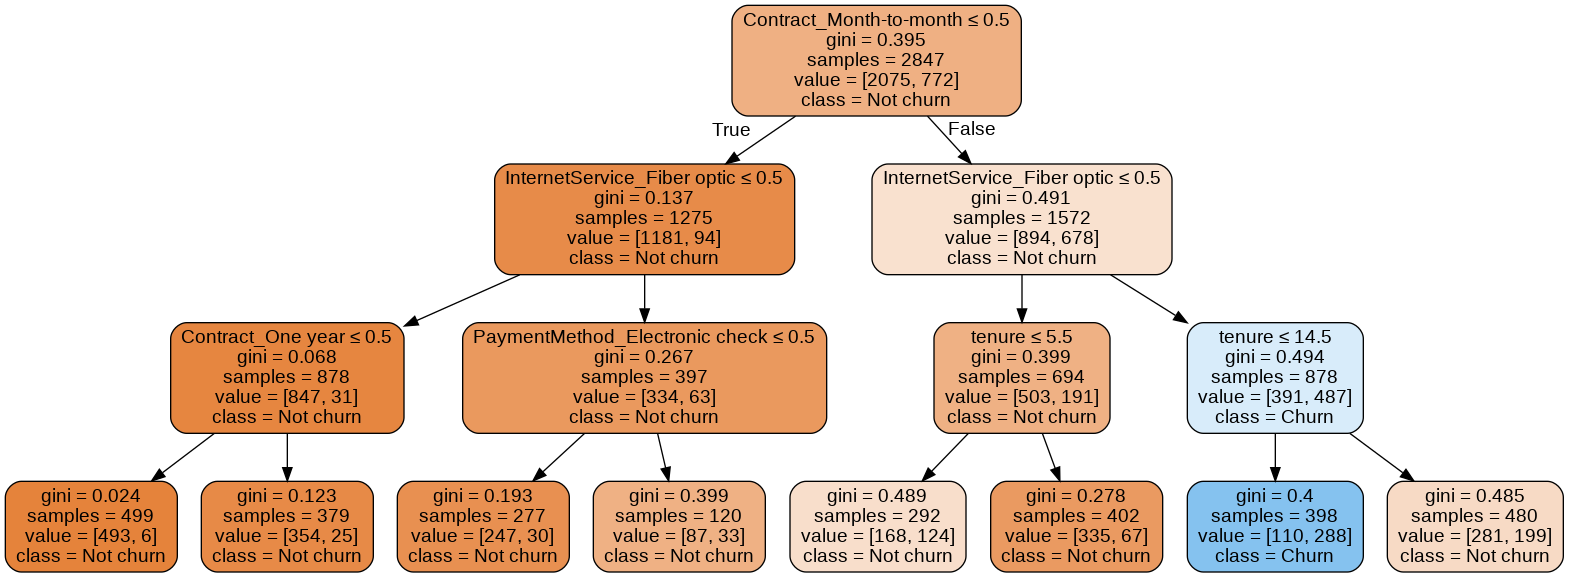

In [18]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(dt_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = X_train.columns.values.tolist(), 
               class_names=['Not churn', 'Churn'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

The gini score is a metric that quantifies the purity of the node/leaf (more about leaves in a bit). A gini score greater than zero implies that samples contained within that node belong to different classes. A gini score of zero means that the node is pure, that within that node only a single class of samples exist. You can find out more about impurity measures here. Notice that we have a gini score greater than zero; therefore, we know that the samples contained within the root node belong to different classes.


In [19]:
from sklearn.metrics import classification_report
pred_dt_binary = dt_model.predict(X_test)
print(classification_report(y_test, pred_dt_binary))

              precision    recall  f1-score   support

           0       0.81      0.93      0.86       953
           1       0.61      0.33      0.43       313

    accuracy                           0.78      1266
   macro avg       0.71      0.63      0.65      1266
weighted avg       0.76      0.78      0.76      1266



Precision tells us how many churned users our classifier predicted correctly. On the other side, recall tell us how many churned users it missed. 

# Random Forests

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()  

print(rf_model)

rf_model.fit(X_train, y_train)  
pred_rf = rf_model.predict_proba(X_test)[:,1]

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [21]:
print(classification_report(y_test, pred_rf.round(0)))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84       953
           1       0.52      0.48      0.50       313

    accuracy                           0.76      1266
   macro avg       0.68      0.67      0.67      1266
weighted avg       0.76      0.76      0.76      1266



n_estimators: This is the number of trees you want to build before taking the maximum voting or averages of predictions. Higher number of trees give you better performance but makes your code slower. You should choose as high value as your processor can handle because this makes your predictions stronger and more stable.



# XGBoost

In [22]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier()

print(xgb_model)

xgb_model.fit(X_train, y_train)
pred_xgb =  xgb_model.predict_proba(X_test)[:, 1]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [26]:
print(classification_report(y_test, pred_xgb.round(0)))

              precision    recall  f1-score   support

           0       0.83      0.88      0.86       953
           1       0.56      0.46      0.51       313

    accuracy                           0.78      1266
   macro avg       0.70      0.67      0.68      1266
weighted avg       0.77      0.78      0.77      1266



# Evaluating model

In [23]:
def create_roc_plot(name, predictions):
  auc = roc_auc_score(y_test, predictions).round(2)
  fpr, tpr, _ = roc_curve(y_test, predictions)

  plt.figure(figsize=(5, 3))
  plt.plot([0, 1], [0, 1], linestyle='--')  # plot horizontal line 
  plt.plot(fpr, tpr, label='{} AUC = {}'.format(name, auc)) # plot the roc curve for the model
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.legend(loc='lower right')  # show the legend
  plt.show() # show the plot
  return None

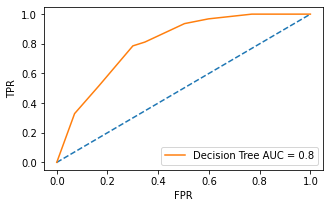

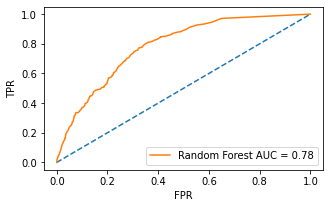

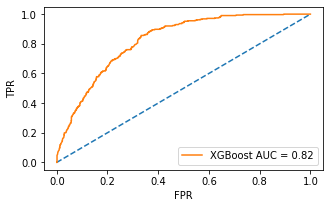

In [24]:
create_roc_plot('Decision Tree', pred_dt)
create_roc_plot('Random Forest', pred_rf)
create_roc_plot('XGBoost', pred_xgb)

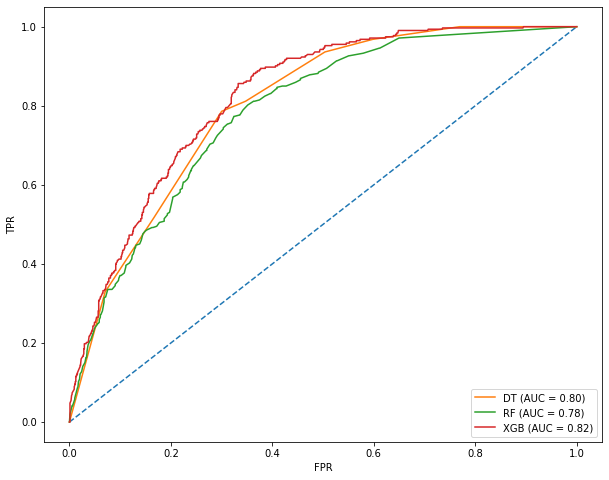

In [25]:
# calculate scores
auc_dt = roc_auc_score(y_test, pred_dt)
auc_rf = roc_auc_score(y_test, pred_rf)
auc_xgb = roc_auc_score(y_test, pred_xgb)

# calculate roc curves
fpr_dt, tpr_dt, _ = roc_curve(y_test, pred_dt)
fpr_rf, tpr_rf, _ = roc_curve(y_test, pred_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, pred_xgb)

plt.figure(figsize=(10, 8))
# plot horizontal line 
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_dt, tpr_dt, label='DT (AUC = %0.2f)' % auc_dt)
plt.plot(fpr_rf, tpr_rf, label='RF (AUC = %0.2f)' % auc_rf)
plt.plot(fpr_xgb, tpr_xgb, label='XGB (AUC = %0.2f)' % auc_xgb)

# axis labels
plt.xlabel('FPR')
plt.ylabel('TPR')
# show the legend
plt.legend(loc='lower right')
# show the plot
plt.show()